In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

from sklearn.metrics import accuracy_score, confusion_matrix
import pickle

from sklearn.inspection import PartialDependenceDisplay
import seaborn as sns

### Feature importance

In [71]:
X = pd.read_csv('../data/processed/outliers_99/X_train.csv', index_col=0).reset_index().drop(['index'], axis=1)
y = pd.read_csv('../data/processed/outliers_99/y_train.csv', index_col=0).reset_index().drop(['index'], axis=1)

In [72]:
target_dict = {-1: 'Low risk', 0:'Low risk', 1:'Low risk', 2:'Moderate_risk', 3:'Moderate_risk', 4:'High risk', 5:'High risk'}
target_list = ['Low risk', 'Moderate_risk', 'High risk']
y = y['churn_risk_score'].map(target_dict)

In [73]:
# Check which features are the most important with the best RandomForest model, since it is part of the VotingClassifier model

In [74]:
with open('../model/strategy2_group_target/outliers_99/best_rf.pkl', 'rb') as file:
    model = pickle.load(file)

In [75]:
model.feature_importances_

array([0.00776481, 0.00114282, 0.00655711, 0.00973176, 0.04303669,
       0.00994732, 0.27646647, 0.00100424, 0.00103337, 0.00073224,
       0.00067414, 0.00825711, 0.00946028, 0.00115878, 0.00105332,
       0.00097784, 0.00089895, 0.0009296 , 0.00092469, 0.00078598,
       0.00091539, 0.0009374 , 0.00083926, 0.01164696, 0.00117753,
       0.0013841 , 0.00133386, 0.00914412, 0.00839931, 0.00997782,
       0.0011687 , 0.01064211, 0.03028437, 0.01200738, 0.13041244,
       0.10018268, 0.03506245, 0.10520784, 0.04838691, 0.05375544,
       0.0445964 ])

In [76]:
X.columns

Index(['age', 'joined_through_referral', 'days_since_last_login',
       'avg_time_spent', 'avg_transaction_value', 'avg_frequency_login_days',
       'points_in_wallet', 'used_special_discount',
       'offer_application_preference', 'past_complaint',
       'is_missing_avg_frequency_login_days',
       'diff_avg_login_freq_last_login_days', 'days_since_joining', 'is_male',
       'region_City', 'region_Missing', 'region_Town', 'region_Village',
       'complaint_status_No Information Available',
       'complaint_status_Not Applicable', 'complaint_status_Solved',
       'complaint_status_Solved in Follow-up', 'complaint_status_Unsolved',
       'feedback_No reason specified', 'feedback_Poor Customer Service',
       'feedback_Poor Product Quality', 'feedback_Poor Website',
       'feedback_Products always in Stock', 'feedback_Quality Customer Care',
       'feedback_Reasonable Price', 'feedback_Too many ads',
       'feedback_User Friendly Website', 'feedback_categroy_Negative',
    

In [77]:
my_dict = {'feature': X.columns,
           'importance': model.feature_importances_}

df = pd.DataFrame(my_dict)
df.to_csv('../feature_importance.csv')

In [78]:
df_sorted = pd.DataFrame(df.sort_values(by='importance', ascending=False))
df_sorted

,feature,importance
6,points_in_wallet,0.276466
34,feedback_categroy_Positive,0.130412
37,membership_category_No Membership,0.105208
35,membership_category_Basic Membership,0.100183
39,membership_category_Premium Membership,0.053755
38,membership_category_Platinum Membership,0.048387
40,membership_category_Silver Membership,0.044596
4,avg_transaction_value,0.043037
36,membership_category_Gold Membership,0.035062
32,feedback_categroy_Negative,0.030284


In [79]:
y.values


array(['High risk', 'Moderate_risk', 'High risk', ..., 'Moderate_risk',
       'High risk', 'Moderate_risk'], dtype=object)

<Axes: xlabel='importance', ylabel='feature'>

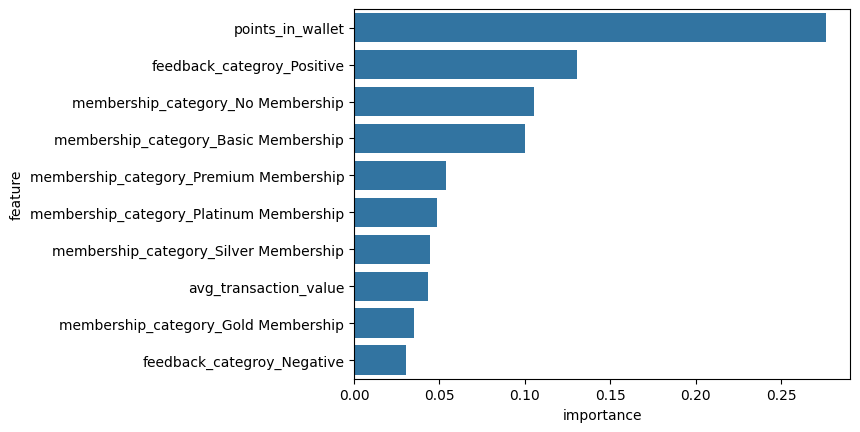

In [80]:
sns.barplot(df_sorted.iloc[:10,:], x='importance', y='feature', orient='h')


### Strategy: Regressor
In order to better see how each feature affects the model, we can train a Regressor. We do not expect it to be accurate, but it will give us insights about how each feature affects the problem

In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

In [82]:
# Import data
X_train = pd.read_csv('../data/processed/outliers_99/X_train.csv', index_col=0).reset_index().drop(['index'], axis=1)
y_train = pd.read_csv('../data/processed/outliers_99/y_train.csv', index_col=0).reset_index().drop(['index'], axis=1)
X_val = pd.read_csv('../data/processed/outliers_99/X_val.csv', index_col=0).reset_index().drop(['index'], axis=1)
y_val = pd.read_csv('../data/processed/outliers_99/y_val.csv', index_col=0).reset_index().drop(['index'], axis=1)

X = pd.concat([X_train, X_val])
y = pd.concat([y_train, y_val])

In [96]:
grid_param = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0], # Total regularization strength
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], # The mixing parameter, where 0 is L2 (Ridge) and 1 is L1 (Lasso)
    'selection': ['cyclic', 'random']
}

gs_lr = GridSearchCV(estimator=ElasticNet(),
                     param_grid=grid_param,
                     cv=4,
                     n_jobs=-1,
                     verbose=2)

gs_lr.fit(X, y)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


GridSearchCV(cv=4, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
                         'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
                         'selection': ['cyclic', 'random']},
             verbose=2)

In [99]:
regressor_model = gs_lr.best_estimator_
gs_lr.best_score_

np.float64(0.5549773369882647)

In [100]:
my_dict = {'feature': X.columns,
           'coefficients': regressor_model.coef_}

df = pd.DataFrame(my_dict)
df_sorted = pd.DataFrame(df.sort_values(by='coefficients', ascending=False))
df_sorted

,feature,coefficients
37,membership_category_No Membership,1.098735
35,membership_category_Basic Membership,1.073298
32,feedback_categroy_Negative,0.016696
15,region_Missing,0.008025
25,feedback_Poor Product Quality,0.006070
13,is_male,0.003117
16,region_Town,0.001977
18,complaint_status_No Information Available,0.001656
10,is_missing_avg_frequency_login_days,0.001638
30,feedback_Too many ads,0.000115


### Conclusions:
The most important features are:
* Points in wallet
* Membership type
* Feedback

##### Factors that decrease risk:
* Points in wallet
* More expensive memberships
* Positive feedback (specially)

##### Factors thar increase risk:
* No membership or basic one
* Negative feedback (specially Poor quality and Missing information)